In [3]:
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.calibration import LabelEncoder
from imblearn.over_sampling import SMOTE  
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import GridSearchCV

In [2]:
feature_dir = '/Users/lamahasbini/Library/CloudStorage/OneDrive-AmericanUniversityofBeirut/FYP 2024-25 ECE/FYP_Fall_2024-2025/ML Implementation/RF_first_try/features'
data_dir = '/Users/lamahasbini/Library/CloudStorage/OneDrive-AmericanUniversityofBeirut/FYP 2024-25 ECE/FYP_Fall_2024-2025/ML Implementation/EDA Analysis Input Files'

# Define signal directories
signal_root_base = '/Users/lamahasbini/Library/CloudStorage/OneDrive-AmericanUniversityofBeirut/FYP 2024-25 ECE/FYP_Fall_2024-2025/ML Implementation/Additional Signals'
signal_roots = {
    'ACC': os.path.join(signal_root_base, 'ACC Input Files'),
    'BVP': os.path.join(signal_root_base, 'BVP Input Files'),
    'HR': os.path.join(signal_root_base, 'HR Input Files'),
    'TEMP': os.path.join(signal_root_base, 'TEMP Input Files'),
}

print("Feature directory:", feature_dir)
print("Data directory:", data_dir)
print("Signal root base:", signal_root_base)
print("Signal directories:")
for signal_type, signal_root in signal_roots.items():
    print(f"{signal_type}: {signal_root}")

Feature directory: /Users/lamahasbini/Library/CloudStorage/OneDrive-AmericanUniversityofBeirut/FYP 2024-25 ECE/FYP_Fall_2024-2025/ML Implementation/RF_first_try/features
Data directory: /Users/lamahasbini/Library/CloudStorage/OneDrive-AmericanUniversityofBeirut/FYP 2024-25 ECE/FYP_Fall_2024-2025/ML Implementation/EDA Analysis Input Files
Signal root base: /Users/lamahasbini/Library/CloudStorage/OneDrive-AmericanUniversityofBeirut/FYP 2024-25 ECE/FYP_Fall_2024-2025/ML Implementation/Additional Signals
Signal directories:
ACC: /Users/lamahasbini/Library/CloudStorage/OneDrive-AmericanUniversityofBeirut/FYP 2024-25 ECE/FYP_Fall_2024-2025/ML Implementation/Additional Signals/ACC Input Files
BVP: /Users/lamahasbini/Library/CloudStorage/OneDrive-AmericanUniversityofBeirut/FYP 2024-25 ECE/FYP_Fall_2024-2025/ML Implementation/Additional Signals/BVP Input Files
HR: /Users/lamahasbini/Library/CloudStorage/OneDrive-AmericanUniversityofBeirut/FYP 2024-25 ECE/FYP_Fall_2024-2025/ML Implementation/Add

In [3]:
def find_signal_file(signal_dir, prefix, patient_id):
    for side in ['LW', 'RW']:
        file_name = f"{prefix}_{patient_id}_{side}.csv"
        file_path = os.path.join(signal_dir, file_name)
        if os.path.exists(file_path):
            return file_path, side
    return None, None

In [5]:
def process_signal_simple(signal_file_path, num_epochs):
    """Process physiological signal files by simply averaging every N samples to match epochs
    
    Args:
        signal_file_path: Path to the signal csv file
        num_epochs: Number of 30-second epochs in the EDA data
        
    Returns:
        List of averaged signal values for each epoch
    """
    try:
        # Read the signal file - first two rows are special (unix timestamp and sampling frequency)
        with open(signal_file_path, 'r') as f:
            first_line = f.readline().strip()
            second_line = f.readline().strip()
            
        # Parse the sampling frequency (we need this to know how many samples per 30 seconds)
        sampling_freq = float(second_line)
        
        # Calculate how many samples correspond to 30 seconds
        samples_per_epoch = int(sampling_freq * 30)
        
        # Read the actual signal values (skip the first two rows)
        signal_data = pd.read_csv(signal_file_path, skiprows=2, header=None, names=['value'])
        total_samples = len(signal_data)
        
        print(f"Signal file has {total_samples} samples at {sampling_freq} Hz")
        print(f"Each 30-second epoch should have ~{samples_per_epoch} samples")
        
        # Initialize the result array
        averaged_values = []
        
        # Process data in chunks of samples_per_epoch
        for i in range(0, min(total_samples, num_epochs * samples_per_epoch), samples_per_epoch):
            # Get a slice of data for this epoch
            end_idx = min(i + samples_per_epoch, total_samples)
            epoch_data = signal_data.iloc[i:end_idx]
            
            if len(epoch_data) > 0:
                # Calculate average for this epoch
                epoch_avg = epoch_data['value'].mean()
                averaged_values.append(epoch_avg)
            else:
                # No data for this epoch
                averaged_values.append(np.nan)
        
        # If we don't have enough data for all epochs, pad with NaN
        while len(averaged_values) < num_epochs:
            averaged_values.append(np.nan)
            
        # If we have too many epochs, trim to match
        if len(averaged_values) > num_epochs:
            averaged_values = averaged_values[:num_epochs]
            
        print(f"Generated {len(averaged_values)} epoch averages, {sum(~np.isnan(averaged_values))} with valid data")
        return averaged_values
        
    except Exception as e:
        print(f"Error processing signal file: {e}")
        return [np.nan] * num_epochs

In [87]:
# Load storm starts for all patients
storm_df = pd.DataFrame()
for file in os.listdir(data_dir):
    if file.endswith('.xlsx'):
        file_path = os.path.join(data_dir, file)
        temp = pd.read_excel(file_path, sheet_name='Sheet1')
        patient_id = file.replace('.xlsx', '').replace('_new', '')
        patient_id_parts = patient_id.split('_')
        patient_id = f"{patient_id_parts[-2]}_{patient_id_parts[-1]}"
        temp['Patient_ID'] = patient_id
        storm_df = pd.concat([storm_df, temp], ignore_index=True)

# Clean storm_df
clean_storm_data = []
for _, row in storm_df.iterrows():
    try:
        start = pd.to_datetime(row['Time_stamp_E4_begin_Synced'], dayfirst=True)
        clean_storm_data.append({'Patient_ID': row['Patient_ID'], 'start': start})
    except:
        continue
storm_df_clean = pd.DataFrame(clean_storm_data)

# Storm timing computation function
def compute_storm_timing_features(df):
    df = df.sort_values('Date_E4_synced').reset_index(drop=True)
    df['time_since_storm_start'] = 0.0
    df['time_since_last_storm'] = 0.0

    last_storm_start_time = None
    last_storm_end_time = None
    in_storm = False

    for i, row in df.iterrows():
        current_time = row['Date_E4_synced']
        storm_flag = row['Storm_mark']

        if storm_flag == 1:
            if not in_storm:
                last_storm_start_time = current_time
                in_storm = True
            df.at[i, 'time_since_storm_start'] = (current_time - last_storm_start_time).total_seconds()
            df.at[i, 'time_since_last_storm'] = 0.0

        elif storm_flag == 0:
            if in_storm:
                # Storm just ended
                last_storm_end_time = df.at[i - 1, 'Date_E4_synced']
                in_storm = False
            df.at[i, 'time_since_storm_start'] = 0.0
            if last_storm_end_time is not None:
                df.at[i, 'time_since_last_storm'] = (current_time - last_storm_end_time).total_seconds()
            else:
                df.at[i, 'time_since_last_storm'] = 0.0

    return df

# Main loop over patient files to process physiological signals
processed_patients = []

for file in os.listdir(feature_dir):
    if file.startswith("Features_") and file.endswith(".csv"):
        feature_path = os.path.join(feature_dir, file)
        features_df = pd.read_csv(feature_path)

        # Extract patient_id from filename - Fix extraction to ensure consistent format
        # Format should be 'Px' where x is the patient number
        original_patient_id = file.replace('Features_', '').replace('.csv', '').replace('_new', '')
        print(f"Original file name: {file}")
        print(f"Extracted patient ID: {original_patient_id}")
        
        # Extract just the patient number for proper matching
        # If format is like P43_LW, extract P43
        if '_' in original_patient_id:
            patient_number = original_patient_id.split('_')[0]
        else:
            patient_number = original_patient_id
            
        print(f"Using patient number: {patient_number} for signal file search")

        # Load corresponding Sheet3 data for this patient
        matched_xlsx = [f for f in os.listdir(data_dir) if original_patient_id in f and f.endswith('.xlsx')]
        if not matched_xlsx:
            print(f"No matching Excel file found for {original_patient_id}")
            continue

        sheet3_path = os.path.join(data_dir, matched_xlsx[0])
        try:
            sheet3_df = pd.read_excel(sheet3_path, sheet_name='Sheet3')
        except:
            print(f"Failed to read Sheet3 for {original_patient_id}")
            continue

        # Handle row count mismatch
        if len(sheet3_df) - len(features_df) == 1:
            sheet3_df = sheet3_df.iloc[:len(features_df)]
        elif len(features_df) != len(sheet3_df):
            print(f"Row mismatch for {original_patient_id}, skipping.")
            continue

        # Add storm mark and date columns to features dataframe
        features_df['Storm_mark'] = sheet3_df['Storm_mark'].values
        features_df['Date_E4_synced'] = pd.to_datetime(sheet3_df['Date_E4_synced'].values)  # Ensure datetime
        features_df['Storm_mark'] = features_df['Storm_mark'].apply(lambda x: 1 if x in [1, 2] else 0)
        
        # Process each physiological signal type
        signal_files_found = []
        
        # Improved function to find signal files - try multiple patient ID formats
        def find_signal_file_improved(signal_dir, prefix, patient_id):
            # Try various combinations of patient ID formats
            possible_patient_ids = [
                patient_id,  # Original extracted ID (e.g., P43_LW)
                patient_id.split('_')[0] if '_' in patient_id else patient_id,  # Just the P number (e.g., P43)
            ]
            
            # For P24_LW2 format, also try P24
            if patient_id.endswith('2') and '_' in patient_id:
                base = patient_id.split('_')[0]
                side = patient_id.split('_')[1].rstrip('2')
                possible_patient_ids.append(base)
                possible_patient_ids.append(f"{base}_{side}")
            
            # Try each possible patient ID
            for p_id in possible_patient_ids:
                print(f"  Trying to find {prefix} file with patient ID: {p_id}")
                for side in ['LW', 'RW']:
                    file_name = f"{prefix}_{p_id}_{side}.csv"
                    file_path = os.path.join(signal_dir, file_name)
                    if os.path.exists(file_path):
                        print(f"  Found file: {file_name}")
                        return file_path, side
                        
            # If exact matches failed, use glob to find partial matches
            for p_id in possible_patient_ids:
                import glob
                pattern = os.path.join(signal_dir, f"{prefix}_{p_id}*.csv")
                matches = glob.glob(pattern)
                if matches:
                    print(f"  Found related file via pattern matching: {os.path.basename(matches[0])}")
                    return matches[0], 'UNKNOWN'
                    
            return None, None
        
        # Dictionary to store signal data for this patient
        signal_data = {}
        
        for signal_type, dir_path in signal_roots.items():
            # Set correct prefix based on signal type
            prefix = 'ACC_abs' if signal_type == 'ACC' else signal_type
            
            # Find signal file with improved function
            file_path, side = find_signal_file_improved(dir_path, prefix, original_patient_id)
            
            if file_path:
                print(f"Found {signal_type} file: {os.path.basename(file_path)}")
                signal_files_found.append(signal_type)
                
                # Process physiological signal data using simple approach
                print(f"Processing {signal_type} signal data from {os.path.basename(file_path)}...")
                try:
                    # Use the simplified function to process signal data by 30-second windows
                    num_epochs = len(features_df)
                    aligned_values = process_signal_simple(file_path, num_epochs)
                    features_df[f"{signal_type}_mean"] = aligned_values
                    
                    # Report how many valid signal values we have
                    valid_count = sum(~pd.isna(aligned_values))
                    print(f"  Added {valid_count}/{len(features_df)} valid {signal_type} values")
                except Exception as e:
                    print(f"  Error processing {signal_type} data: {e}")
                    features_df[f"{signal_type}_mean"] = np.nan
            else:
                print(f"No {signal_type} file found for {original_patient_id}")
                features_df[f"{signal_type}_mean"] = np.nan
        
        if not signal_files_found:
            print(f"Warning: No signal files found for {original_patient_id}")
        
        # Get storm times
        patient_storms = storm_df_clean[storm_df_clean['Patient_ID'] == original_patient_id]
        storm_start_times = patient_storms['start'].tolist()

        if not storm_start_times:
            print(f"No storms found for {original_patient_id}, skipping storm features.")
            continue

        # Compute storm timing features in-place
        features_df = compute_storm_timing_features(features_df)
        
        # Verify before saving to CSV that we have signal data
        signal_columns = [f"{signal_type}_mean" for signal_type in signal_files_found]
        for col in signal_columns:
            if col in features_df.columns:
                non_null_count = features_df[col].count()
                print(f"  Column {col}: {non_null_count}/{len(features_df)} non-null values")
        
        # Make a backup of the original file
        import shutil
        backup_path = feature_path + '.bak'
        try:
            shutil.copy2(feature_path, backup_path)
            print(f"Created backup of original file at {backup_path}")
        except Exception as e:
            print(f"Warning: Could not create backup: {e}")
            
        # Save the DataFrame - just to be safe, we'll catch any exceptions
        try:
            features_df.to_csv(feature_path, index=False)
            print(f"Updated file: {file}\n")
            processed_patients.append(original_patient_id)
        except Exception as e:
            print(f"Error saving file {file}: {e}")
            continue

print(f"Processing complete. Processed {len(processed_patients)} patients.")

Original file name: Features_P43_LW.csv
Extracted patient ID: P43_LW
Using patient number: P43 for signal file search
  Trying to find ACC_abs file with patient ID: P43_LW
  Trying to find ACC_abs file with patient ID: P43
  Found file: ACC_abs_P43_LW.csv
Found ACC file: ACC_abs_P43_LW.csv
Processing ACC signal data from ACC_abs_P43_LW.csv...
Signal file has 804097 samples at 32.0 Hz
Each 30-second epoch should have ~960 samples
Generated 844 epoch averages, 838 with valid data
  Added 838/844 valid ACC values
  Trying to find BVP file with patient ID: P43_LW
  Trying to find BVP file with patient ID: P43
  Found file: BVP_P43_LW.csv
Found BVP file: BVP_P43_LW.csv
Processing BVP signal data from BVP_P43_LW.csv...
Signal file has 1608193 samples at 64.0 Hz
Each 30-second epoch should have ~1920 samples
Generated 844 epoch averages, 838 with valid data
  Added 838/844 valid BVP values
  Trying to find HR file with patient ID: P43_LW
  Trying to find HR file with patient ID: P43
  Found f

In [4]:
output_folder = "/Users/lamahasbini/Library/CloudStorage/OneDrive-AmericanUniversityofBeirut/FYP 2024-25 ECE/FYP_Fall_2024-2025/ML Implementation/RF_first_try/features"
features_df = pd.DataFrame()

for file in os.listdir(output_folder):
    if file.endswith('.csv'):
        file_path = os.path.join(output_folder, file)
        temp = pd.read_csv(file_path)
        parts = file.replace('.csv', '').split('_')
        patient_id = f"{parts[-2]}_{parts[-1]}"
        
        temp['Patient_ID'] = patient_id  
        features_df = pd.concat([features_df, temp], ignore_index=True)

In [5]:
# Display signal data columns and check for missing values
signal_columns = ['ACC_mean', 'BVP_mean', 'HR_mean', 'TEMP_mean']
for col in signal_columns:
    if col in features_df.columns:
        non_null_count = features_df[col].count()
        total_count = len(features_df)
        coverage_percent = (non_null_count / total_count) * 100
        print(f"{col}: {non_null_count}/{total_count} non-null values ({coverage_percent:.2f}%)")

ACC_mean: 45620/46079 non-null values (99.00%)
BVP_mean: 45321/46079 non-null values (98.35%)
HR_mean: 45620/46079 non-null values (99.00%)
TEMP_mean: 45620/46079 non-null values (99.00%)


In [6]:
features_df['Sleep_stage'] = features_df['Sleep_stage'].astype(str)
features_df['Sleep_stage'] = features_df['Sleep_stage'].replace('3', '2')
features_df['Sleep_stage'] = features_df['Sleep_stage'].replace('r', 'R')

In [7]:
features_df.isnull().sum()

Mode                        23
Median                      23
MaxAbs                      23
LineLength                  23
10thQuantile                23
75thQuantile                23
NonLinearEnergy             23
SVD_Entropy               1071
ShannonEntropy              23
Average EDA per epoch      374
EDR_count                  374
Storm_mark                   0
Sleep_stage                  0
Age                          0
Gender                       0
Date_E4_synced               0
time_since_storm_start       0
time_since_last_storm        0
ACC_mean                   459
BVP_mean                   758
HR_mean                    459
TEMP_mean                  459
Date_E4_TZ                   0
Date_E4_synced_str           0
Patient_ID                   0
dtype: int64

In [8]:
features_df = features_df.dropna()

In [9]:
X = features_df.drop(['Sleep_stage', 'Patient_ID', 'Date_E4_synced', 'Date_E4_TZ', 'Date_E4_synced_str'], axis=1)
print(X)

y = features_df['Sleep_stage']

           Mode    Median    MaxAbs  LineLength  10thQuantile  75thQuantile  \
0      0.256090  0.257795  4.000000    3.745123      0.256178      0.258123   
1      0.256271  0.259584  0.260198    0.004233      0.256971      0.260031   
2      0.259068  0.260004  0.260528    0.002677      0.259153      0.260201   
3      0.260592  0.261212  0.261553    0.002090      0.260943      0.261330   
4      0.260543  0.261351  0.261547    0.002381      0.260657      0.261450   
...         ...       ...       ...         ...           ...           ...   
46065  0.137638  0.137941  0.138195    0.001070      0.137677      0.138141   
46066  0.137972  0.138280  0.138386    0.001013      0.138009      0.138361   
46067  0.137700  0.138069  0.138328    0.001106      0.137738      0.138220   
46068  0.137539  0.137900  0.138212    0.001516      0.137614      0.138015   
46069  0.137605  0.138057  0.138410    0.001851      0.137698      0.138261   

       NonLinearEnergy   SVD_Entropy  ShannonEntrop

In [10]:
if "Gender" in X.columns:
    le = LabelEncoder()
    X["Gender"] = le.fit_transform(X["Gender"])  # Converts 'Female' -> 0, 'Male' -> 1

sm = SMOTE(random_state=42)
X, y = sm.fit_resample(X, y)

/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
rf_best = RandomForestClassifier(
    class_weight='balanced',
    random_state=42,
    bootstrap=False,
    max_depth=None,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=200
)

rf_best.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       n_estimators=200, random_state=42)

In [13]:
y_pred = rf_best.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.85      0.89      0.87      4772
           2       0.93      0.94      0.93      4862
           R       0.94      0.94      0.94      4943
           W       0.91      0.86      0.89      4737

    accuracy                           0.91     19314
   macro avg       0.91      0.91      0.91     19314
weighted avg       0.91      0.91      0.91     19314



Total inference time for 19314 samples: 0.5543 seconds
Average inference time per sample: 0.0287 milliseconds

Inference time for different batch sizes:
Batch size: 1, Total time: 0.0049 sec, Avg per sample: 4.9002 ms
Batch size: 10, Total time: 0.0058 sec, Avg per sample: 0.5809 ms
Batch size: 100, Total time: 0.0133 sec, Avg per sample: 0.1328 ms
Batch size: 1000, Total time: 0.0594 sec, Avg per sample: 0.0594 ms


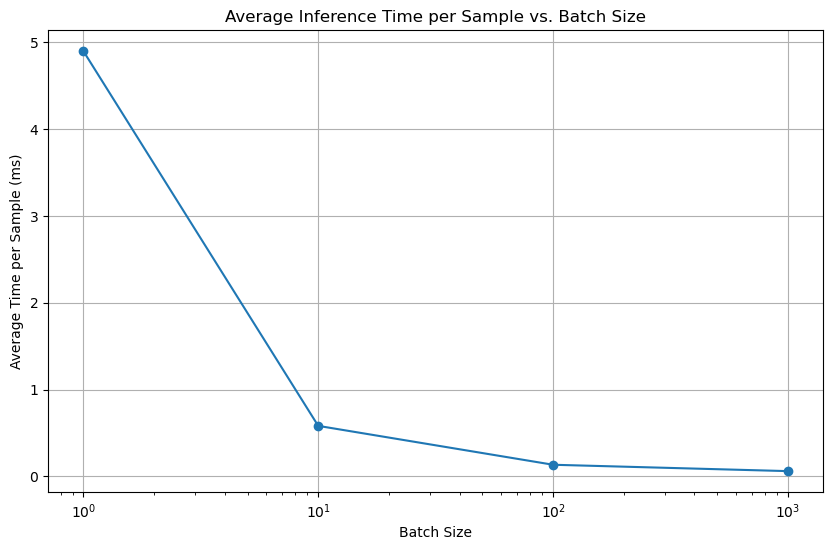

In [16]:
import time

# Measure inference time for individual predictions
start_time = time.time()

# Make predictions on the test set
y_pred = rf_best.predict(X_test)

end_time = time.time()
total_time = end_time - start_time
avg_inference_time = (total_time / len(X_test)) * 1000  # Convert to milliseconds

print(f"Total inference time for {len(X_test)} samples: {total_time:.4f} seconds")
print(f"Average inference time per sample: {avg_inference_time:.4f} milliseconds")

# Measure inference time for batches of different sizes
batch_sizes = [1, 10, 100, 1000]
results = []

for batch_size in batch_sizes:
    if batch_size <= len(X_test):
        # Take a subset of the test data
        X_batch = X_test.iloc[:batch_size]
        
        # Time the prediction
        start_time = time.time()
        rf_best.predict(X_batch)
        end_time = time.time()
        
        batch_time = end_time - start_time
        avg_time_per_sample = (batch_time / batch_size) * 1000  # Convert to milliseconds
        
        results.append({
            'batch_size': batch_size,
            'total_time': batch_time,
            'avg_time_per_sample': avg_time_per_sample
        })

# Display results
print("\nInference time for different batch sizes:")
for result in results:
    print(f"Batch size: {result['batch_size']}, Total time: {result['total_time']:.4f} sec, "
          f"Avg per sample: {result['avg_time_per_sample']:.4f} ms")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot([r['batch_size'] for r in results], [r['avg_time_per_sample'] for r in results], 'o-')
plt.title('Average Inference Time per Sample vs. Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('Average Time per Sample (ms)')
plt.xscale('log')  # Use logarithmic scale for batch size
plt.grid(True)
plt.show()

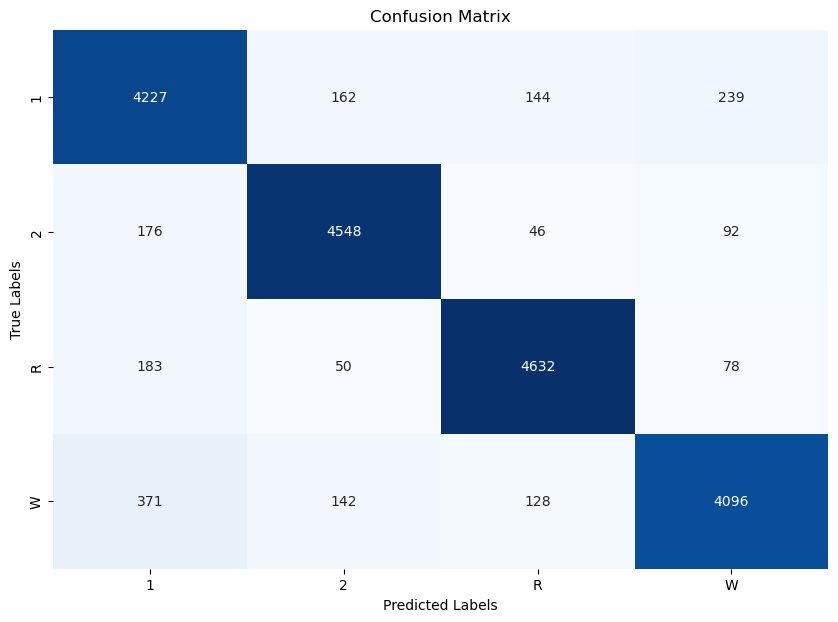

In [14]:
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))  # Set the size of the plot
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', 
            xticklabels=['1', '2', 'R', 'W'],  
            yticklabels=['1', '2', 'R', 'W'],
            cbar=False)  # Disable color bar

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [99]:
param_grid = {
    'n_estimators': [150, 200, 250],
    'max_depth': [None, 20, 30],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2],
    'bootstrap': [False]  # since it was already preferred
}

In [100]:
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)

Best parameters: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 250}


In [15]:
rf_best = RandomForestClassifier(
    class_weight='balanced',
    random_state=42,
    bootstrap=False,
    max_depth=30,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=250
)

rf_best.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=30,
                       n_estimators=250, random_state=42)

In [16]:
y_pred = rf_best.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.85      0.88      0.87      4772
           2       0.93      0.94      0.93      4862
           R       0.93      0.94      0.94      4943
           W       0.91      0.86      0.89      4737

    accuracy                           0.91     19314
   macro avg       0.91      0.91      0.91     19314
weighted avg       0.91      0.91      0.91     19314



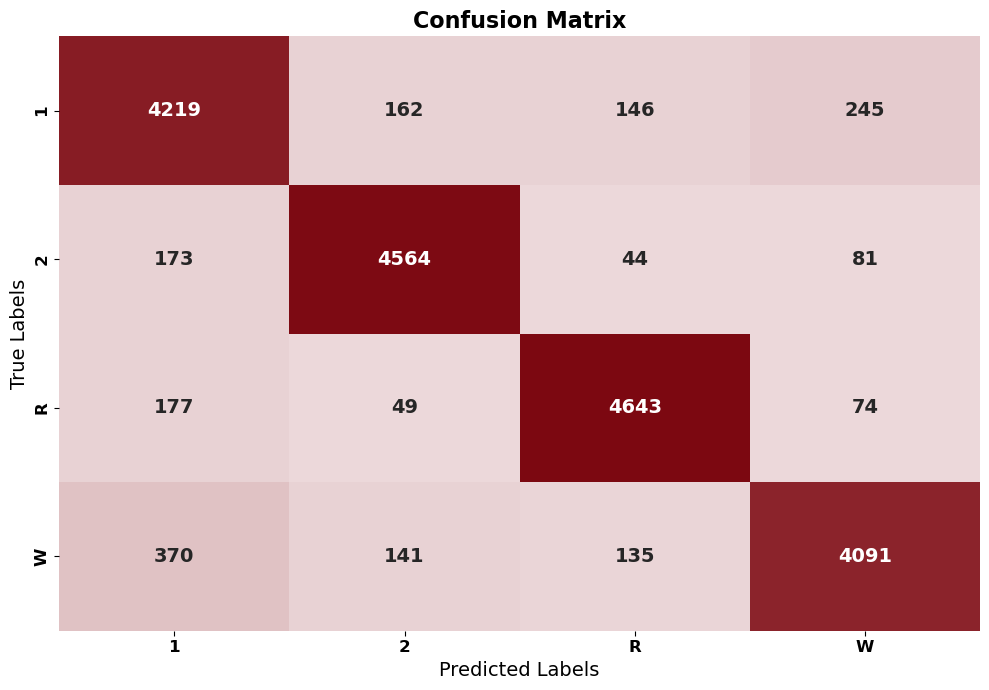

In [33]:
from matplotlib.colors import LinearSegmentedColormap

# Create a custom colormap with your red shades
red_colors = ['#ecd8da', '#b26e73', '#a45258', '#7c0811']  # Lightest to darkest
custom_red_cmap = LinearSegmentedColormap.from_list('custom_red', red_colors, N=100)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))  # Set the size of the plot
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap=custom_red_cmap, 
            xticklabels=['1', '2', 'R', 'W'],  
            yticklabels=['1', '2', 'R', 'W'],
            cbar=False,  # Disable color bar
            annot_kws={"size": 14, "weight": "bold"})  # Make the numbers more visible

# Increase font sizes for better readability
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

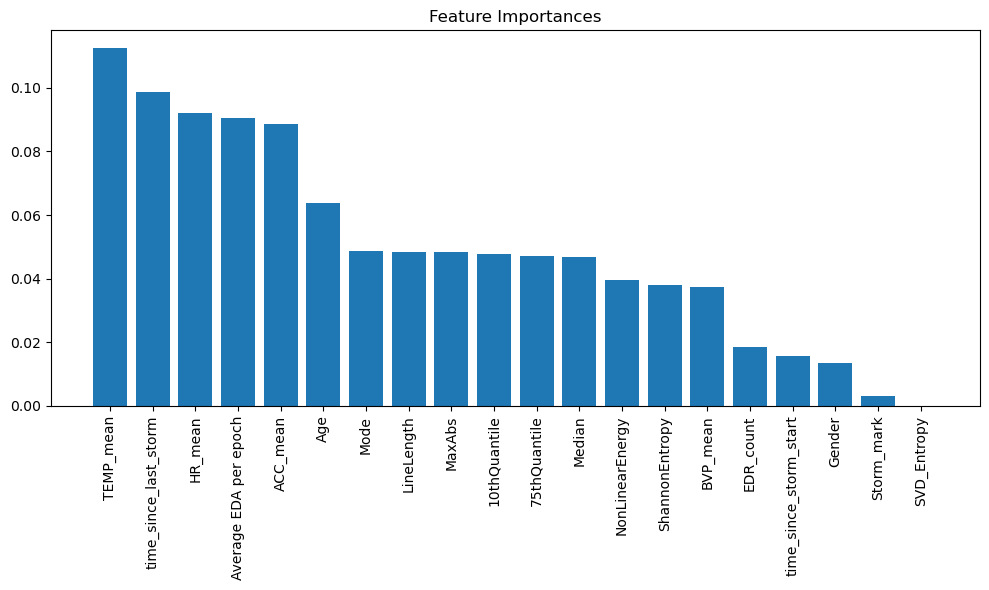

In [18]:
importances = rf_best.feature_importances_
feature_names = X_train.columns  # or a list of your feature names
indices = np.argsort(importances)[::-1]  # sort descending

# Plot
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()

/var/folders/xp/nsdfv7c175v6fr_sd8q514780000gn/T/ipykernel_15333/2407660308.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


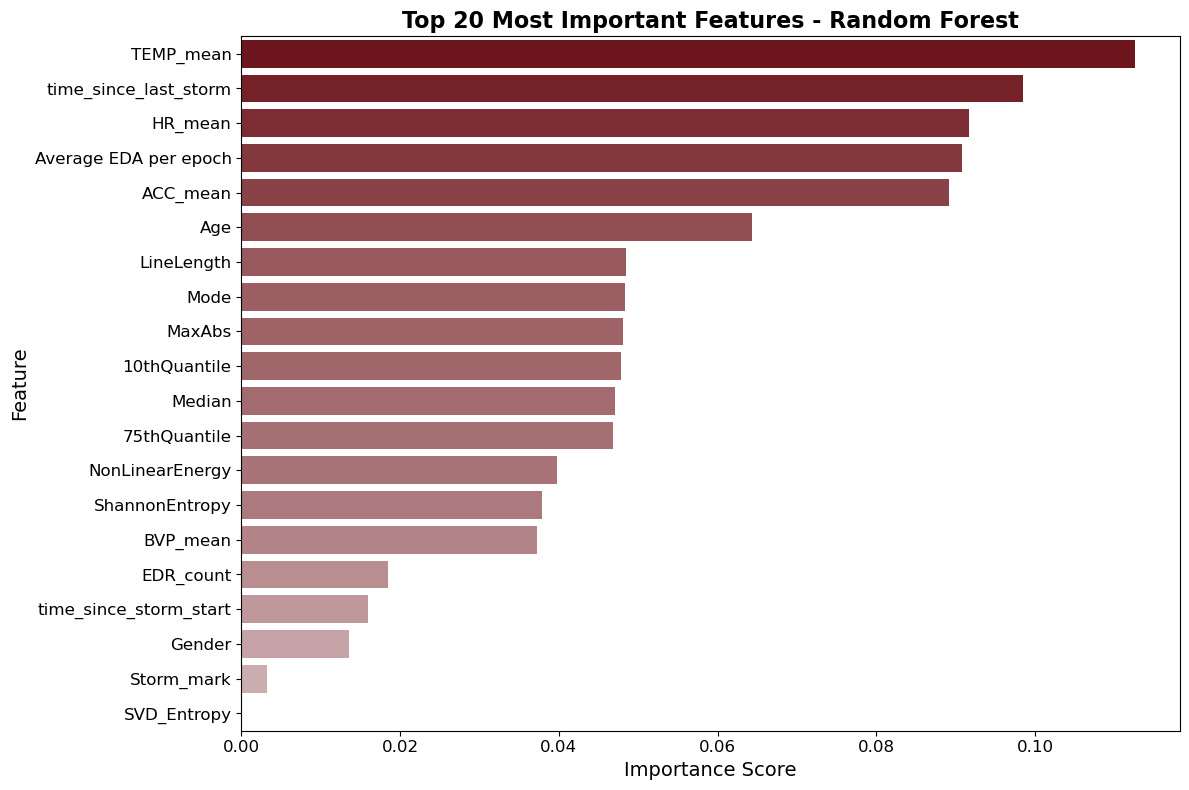

In [26]:
# === Enhanced Feature Importance Plot ===
importances = rf_best.feature_importances_
feature_names = X.columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot the top 20 features (or all if less than 20)
num_features = min(20, len(importance_df))
plt.figure(figsize=(12, 8))

# Create a custom red palette with 20 shades based on the provided hex codes
from matplotlib.colors import LinearSegmentedColormap

# Define key colors from your original hex values in order from darkest to lightest
base_colors = ['#7c0811', '#a45258', '#b26e73', '#d6b1b5']

# Create a smoother color map with 20 colors
custom_red_cmap = LinearSegmentedColormap.from_list('custom_red', base_colors, N=20)

# Manually create color array with darkest at top (first/most important feature)
# Using i/19 directly (not 1-i/19) will assign darkest color (index 0) to the top feature
custom_reds = [custom_red_cmap(i/19) for i in range(num_features)]

# Use the custom palette for the barplot
# Use the custom palette for the barplot
sns.barplot(
    data=importance_df.head(num_features), 
    x='Importance', 
    y='Feature', 
    palette=custom_reds  # <-- no reversing
)

# Remove the automatically added legend
plt.legend([],[], frameon=False)

# Adjust text properties for better readability
plt.title('Top 20 Most Important Features - Random Forest', fontsize=16, fontweight='bold')
plt.xlabel('Importance Score', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

/var/folders/xp/nsdfv7c175v6fr_sd8q514780000gn/T/ipykernel_15333/3078197913.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=importance_df.head(num_features), x='Importance', y='Feature', palette=custom_reds)


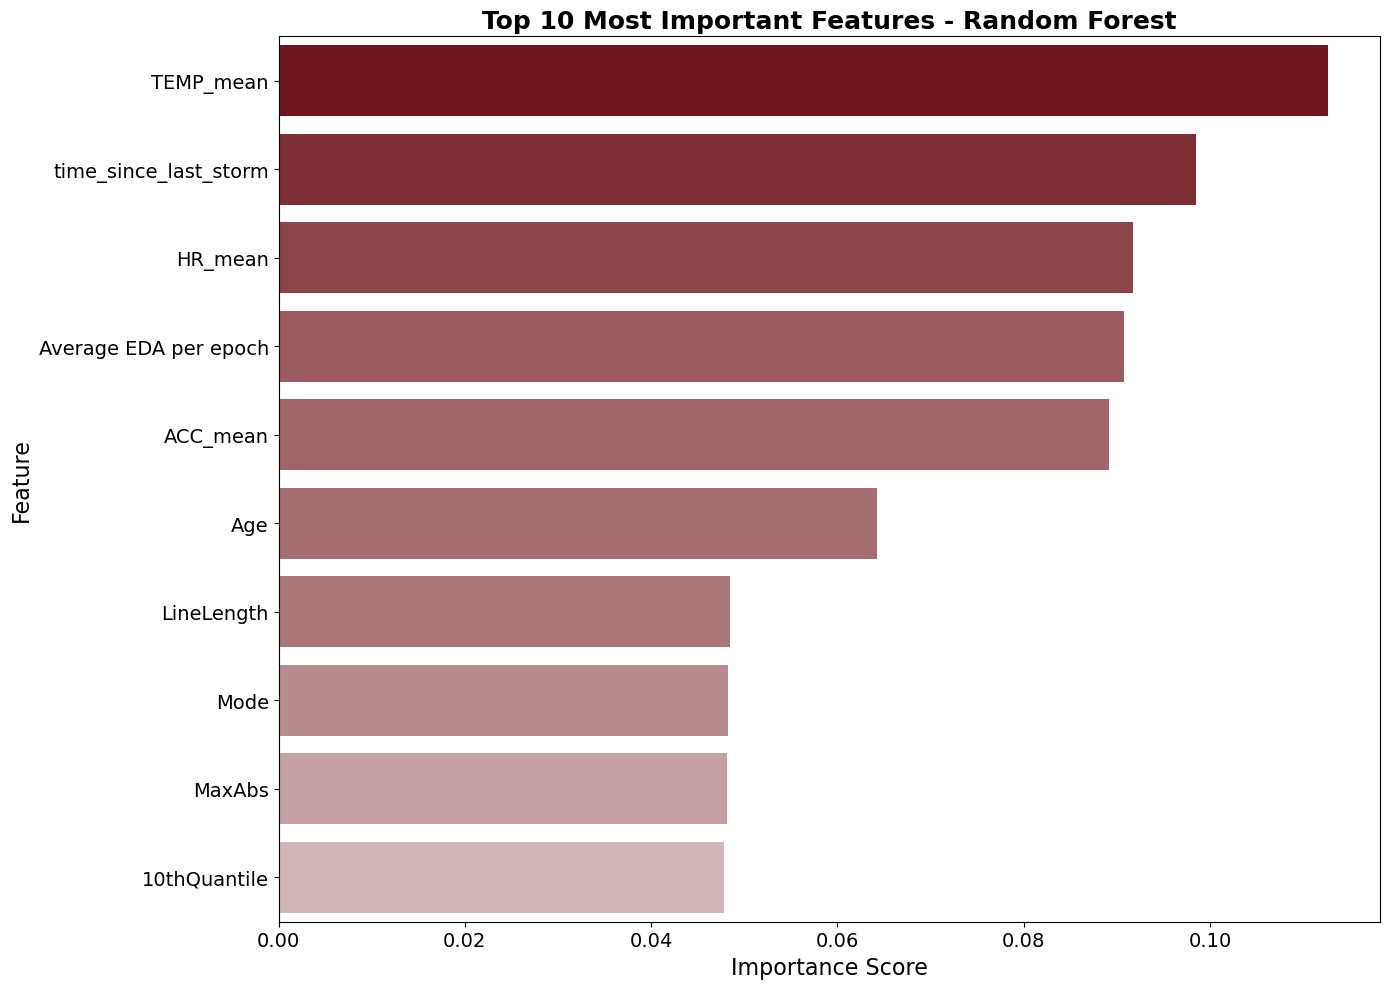

In [34]:
# === Enhanced Feature Importance Plot ===
importances = rf_best.feature_importances_
feature_names = X.columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot the top 10 features (or all if less than 10)
num_features = min(10, len(importance_df))
plt.figure(figsize=(14, 10))

# === Custom Red Palette ===
from matplotlib.colors import LinearSegmentedColormap

# Define key colors
base_colors = ['#7c0811', '#a45258', '#b26e73', '#d6b1b5']

# Create a smoother color map with 10 colors for top 10
custom_red_cmap = LinearSegmentedColormap.from_list('custom_red', base_colors, N=10)

# Generate the list of 10 color shades
custom_reds = [custom_red_cmap(i/9) for i in range(num_features)]  # i/9 because 0 to 9

# Create bar plot using the custom red colors
ax = sns.barplot(data=importance_df.head(num_features), x='Importance', y='Feature', palette=custom_reds)

# Increase font sizes
plt.title('Top 10 Most Important Features - Random Forest', fontsize=18, fontweight='bold')
plt.xlabel('Importance Score', fontsize=16)
plt.ylabel('Feature', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()